# RSO Data Processing

Function rsoOrbits() in the following script carries out the following:
1. Dowloands TLE information from https://www.space-track.org/ for duration specified by the user.
2. Computes mean and standard deviation for orbital elements.
3. Creates 3D orbit visualisation of the objects.

## Requirements
1. Apart from common python packages, Skyfield package is required. (Can be installed using: pip install skyfield).
2. Active internet connection (for downloading TLE and Ephemeris data).
3. An account at https://www.space-track.org/.

Enter username: kapishaggarwal@yahoo.com
Enter password: ········
Enter name of space object list file: test_rso.txt
Enter starting epoch date (YYYY-MM-DD): 2021-03-01
Enter terminal epoch date (YYYY-MM-DD): 2021-03-31

The following NORAD_CAT_ID's are being searched: 
43939, 44037, 44064, 44066, 44117, 44118, 44119, 44120, 44121, 44122.

Following obects do not have TLE data available for the requested date range: 
43939, 44117, 44118, 44119, 44120, 44121, 44122.
Therefore, data is being added for last 75 entries in the space-track.org's database.

... working on object number 43939 ...
... done with object number 43939

... working on object number 44117 ...
... done with object number 44117

... working on object number 44118 ...
... done with object number 44118

... working on object number 44119 ...
... done with object number 44119

... working on object number 44120 ...
... done with object number 44120

... working on object number 44121 ...
... done with object number 44121



,Object,Duration of TLE data [days],Last Epoch,e mean [-],e std [-],a mean [km],a std [km],RAAN mean [°],RAAN std [°],AP mean [°],AP std [°],i mean [°],i std [°]
NORAD_CAT_ID,,,,,,,,,,,,,
43939,EPSILON DEB,23,2019-08-07,0.008605,0.003319,6622.309093,34.548384,273.155661,7.308402,153.889581,26.631308,97.101161,0.005486
44037,ARIANE 5 DEB (SYLDA),30,2021-03-30,0.726855,0.000188,24325.635611,1.652002,316.865657,3.294207,94.007404,6.925277,3.107279,0.007641
44064,CREW DRAGON DEMO-1 DEB,30,2021-03-30,0.000203,0.000083,6709.300284,3.108882,180.274249,145.325300,82.078721,72.441553,51.626081,0.000811
44066,S5 DEB,29,2021-03-30,0.000173,0.000056,42529.147759,0.551330,92.239074,0.104610,120.724887,25.500163,1.685126,0.021602
44117,MICROSAT-R DEB,31,2019-12-22,0.021346,0.006930,6773.110373,58.216112,162.417657,6.734371,249.528837,33.152796,95.248855,0.008216
44118,MICROSAT-R DEB,5,2019-04-08,0.018639,0.005371,6768.841500,42.575395,8.777463,1.486156,347.078937,5.342475,96.139913,0.016931
44119,MICROSAT-R DEB,1,2019-04-04,0.018125,NaN,6706.654000,NaN,4.643700,NaN,28.469100,NaN,94.917800,NaN
44120,MICROSAT-R DEB,30,2019-07-09,0.015856,0.006091,6734.141613,53.603833,65.551467,7.119734,77.679157,73.094516,95.481173,0.006203
44121,MICROSAT-R DEB,25,2019-04-29,0.021800,0.009014,6785.315294,79.079277,15.049084,6.052104,305.270294,33.563892,95.568365,0.008800


<IPython.core.display.Javascript object>


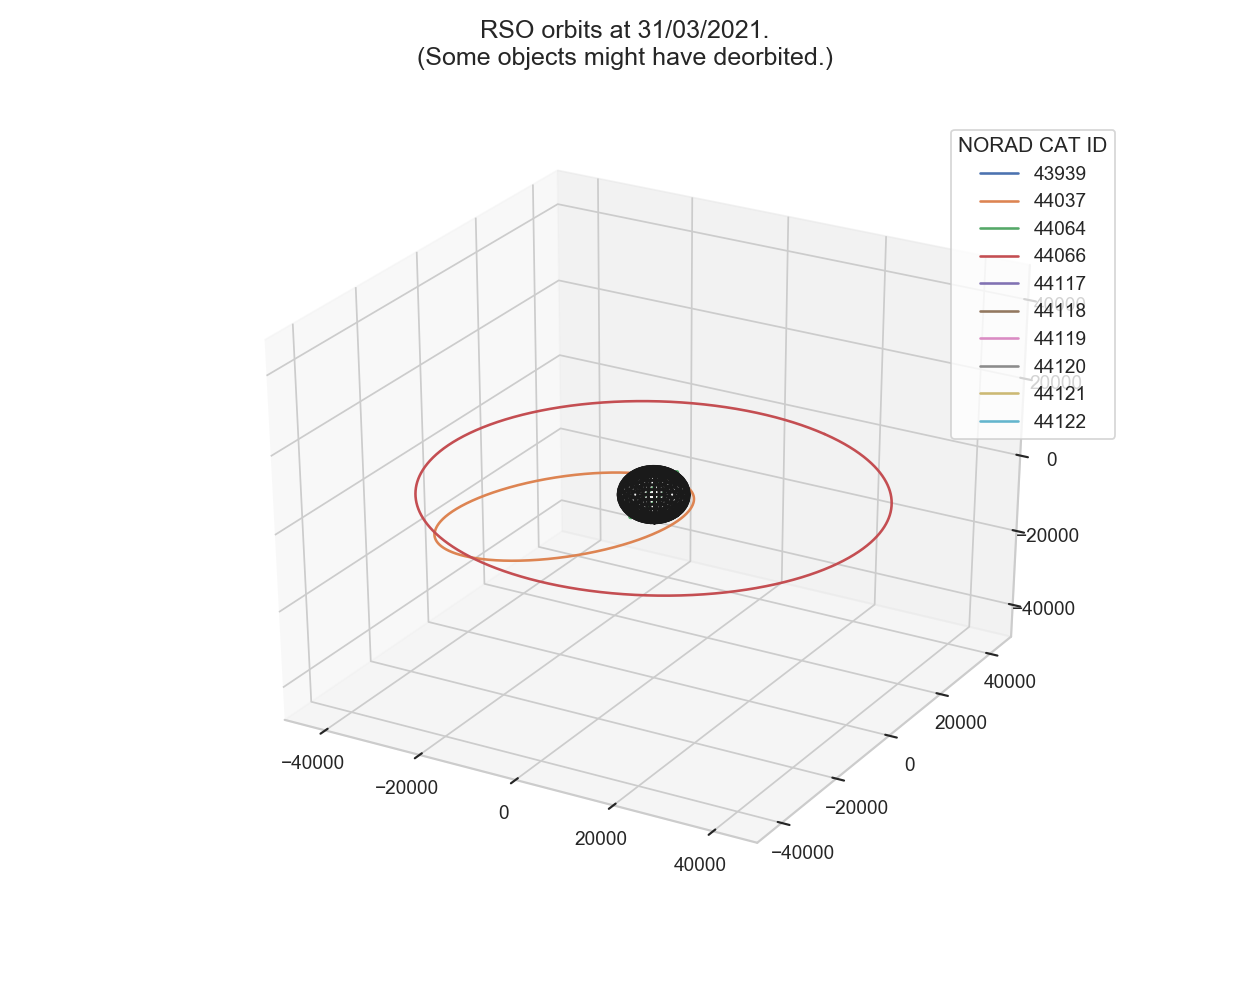

<IPython.core.display.Javascript object>


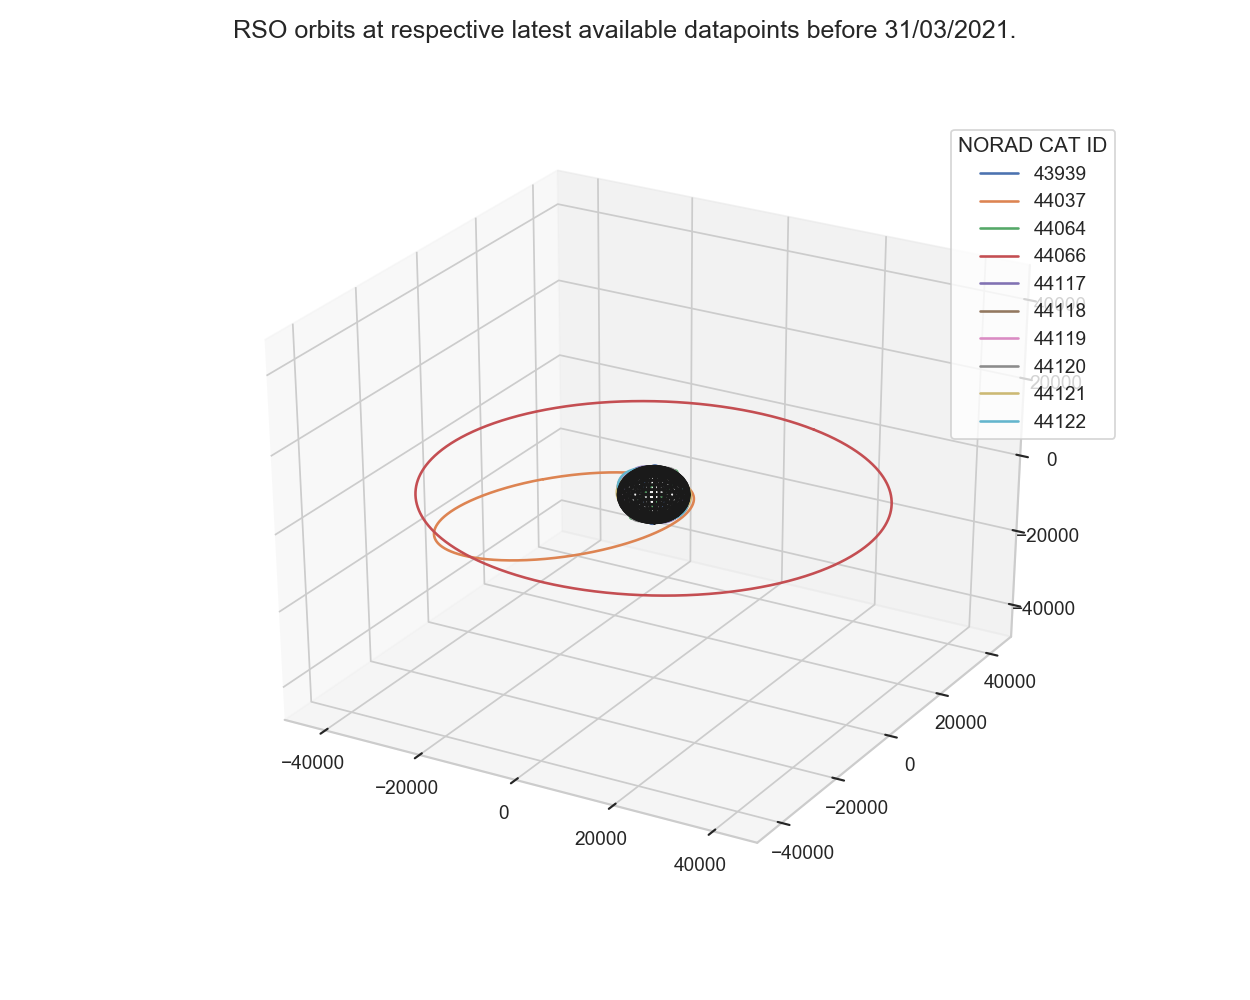

In [1]:
def rsoOrbits():
    
    # Importing libraries
    import requests
    import json
    import pandas as pd
    import getpass
    import datetime
    from skyfield.api import Loader, EarthSatellite
    from skyfield.timelib import Time
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    from mpl_toolkits.mplot3d import Axes3D
    
    # Getting user inputs
    username = input("Enter username: ")
    password = getpass.getpass(prompt = "Enter password: ")
    rso_fileName = input("Enter name of space object list file: ")
    startingDate = input("Enter starting epoch date (YYYY-MM-DD): ")
    terminalDate = input("Enter terminal epoch date (YYYY-MM-DD): ")
    
    # Converting date string to datetime object
    startingDate_obj = datetime.datetime.strptime(startingDate, '%Y-%m-%d')
    terminalDate_obj = datetime.datetime.strptime(terminalDate, '%Y-%m-%d')
    duration = (terminalDate_obj-startingDate_obj).days
    
    # Loading Data
    rso_list = pd.read_csv(rso_fileName, header = None, index_col = False) # Reading objest list file into dataframe.
    rso_list = rso_list.transpose()[0]  # Converting dataframe to series.
    rso_list = rso_list.astype(int)     # Converting to int to remove space or other characters and for later use.
    rso_list_string = ", ".join([str(rso) for rso in rso_list]) # converting again to string and joining for accessing api.
    
    print("\nThe following NORAD_CAT_ID's are being searched: \n" + rso_list_string + ".\n")
    
    class MyError(Exception):
        def __init___(self,args):
            Exception.__init__(self,"my exception was raised with arguments {0}".format(args))
            self.args = args

    # Credentials for using the site
    siteCred = {'identity': username, 'password': password}
    
    # Forming REST query for accessing https://www.space-track.org
    uriBase                   = "https://www.space-track.org"
    requestLogin              = "/ajaxauth/login"
    requestControlerAndAction = "/basicspacedata/query"
    requestTleData = ( "/class/gp_history/NORAD_CAT_ID/"
                  + rso_list_string + 
                  "/orderby/TLE_LINE1%20ASC/EPOCH/"
                  + startingDate + "--" + terminalDate +
                  "/format/json" )
    
    # Using requests package to drive the RESTful session with space-track.org
    with requests.Session() as session:
        # run the session in a with block to force session to close if we exit

        # need to log in first. note that we get a 200 to say the web site got the data, not that we are logged in
        resp = session.post(uriBase + requestLogin, data = siteCred)
        if resp.status_code != 200:
            raise MyError(resp, "POST fail on login")
        
        # This query picks up all the objects' TLEs from the catalog for the specified dates.
        # Note - a 401 failure shows you have bad credentials 
        resp = session.get(uriBase + requestControlerAndAction + requestTleData)
        if resp.status_code != 200:
            print(resp)
            raise MyError(resp, "GET fail on request for satellites")
    
        tleData_df = pd.read_json(resp.text)
    
        session.close()
    
    
    ## IF SOME OBJECTS WERE NOT AVAILABLE IN THE SPECIFIED DATES, FOLLOWING IS PERFORMED
    rso_list_DateNA = rso_list[~rso_list.isin(tleData_df['NORAD_CAT_ID'].unique())]
    if len(rso_list_DateNA) != 0 :
        NoOfLatestTLEs = int( duration * 2.5 )
        print("Following obects do not have TLE data available for the requested date range: \n" + 
             (", ".join([str(rso) for rso in rso_list_DateNA]) ) + ".") 
        print("Therefore, data is being added for last "+ str(NoOfLatestTLEs)+ " entries in the space-track.org's database.")
    
        for rso in rso_list_DateNA:
            print("\n... working on object number "+str(rso)+" ...")
            requestTleData = ( "/class/gp_history/NORAD_CAT_ID/"
                              + str(rso) + 
                              "/orderby/TLE_LINE1%20DESC/limit/"
                              + str(NoOfLatestTLEs) +
                              "/format/json" )
            
            # use requests package to drive the RESTful session with space-track.org
            with requests.Session() as session:
                # run the session in a with block to force session to close if we exit

                # need to log in first. note that we get a 200 to say the web site got the data, not that we are logged in
                resp = session.post(uriBase + requestLogin, data = siteCred)
                if resp.status_code != 200:
                    raise MyError(resp, "POST fail on login")
        
                # this query picks up all Starlink satellites from the catalog. Note - a 401 failure shows you have bad credentials 
                resp = session.get(uriBase + requestControlerAndAction + requestTleData)
                if resp.status_code != 200:
                    print(resp)
                    raise MyError(resp, "GET fail on request for Starlink satellites")
    
                tleData_df = tleData_df.append(pd.read_json(resp.text))
    
                session.close()
            print("... done with object number "+str(rso))
    
    
    # DATA CLEANING
    relevantCol = ['NORAD_CAT_ID', 'CREATION_DATE',
                   'TLE_LINE0', 'TLE_LINE1', 'TLE_LINE2',
                   'ECCENTRICITY', 'SEMIMAJOR_AXIS', 'RA_OF_ASC_NODE',
                   'ARG_OF_PERICENTER', 'INCLINATION', 'PERIOD', 'EPOCH']
    tleData_df = tleData_df[relevantCol]
    tleData_df['EPOCH'] = pd.to_datetime(tleData_df['EPOCH'], format='%Y-%m-%d')
    tleData_df.set_index(['NORAD_CAT_ID','CREATION_DATE'], inplace = True)
    tleData_df.sort_index(inplace = True)

    
    # CALCULATING MEANS AND STANDARD DEVIATIONS (std)
    # Dataframe preparation
    means_std_df = pd.DataFrame(index=tleData_df.index)
    means_std_df['Object'] = tleData_df['TLE_LINE0'].str[2:]
    means_std_df['Duration of TLE data [days]'] = ""
    for index, new_df in tleData_df.groupby(level=0):
        means_std_df['Duration of TLE data [days]'].loc[index] = \
        (new_df['EPOCH'].iloc[-1] - new_df['EPOCH'].iloc[0]).days + 1
    means_std_df['Last Epoch'] = tleData_df['EPOCH'].dt.date
    means_std_df = means_std_df.droplevel(level=1)
    means_std_df = means_std_df[~means_std_df.index.duplicated(keep='last')]
    
    # Filing in the means and std's in dataframe
    means_std_df['e mean [-]'] = tleData_df['ECCENTRICITY'].groupby(level=0).mean()
    means_std_df['e std [-]'] = tleData_df['ECCENTRICITY'].groupby(level=0).std()

    means_std_df['a mean [km]'] = tleData_df['SEMIMAJOR_AXIS'].groupby(level=0).mean()
    means_std_df['a std [km]'] = tleData_df['SEMIMAJOR_AXIS'].groupby(level=0).std()

    means_std_df['RAAN mean ['+chr(176)+']'] = tleData_df['RA_OF_ASC_NODE'].groupby(level=0).mean()
    means_std_df['RAAN std ['+chr(176)+']'] = tleData_df['RA_OF_ASC_NODE'].groupby(level=0).std()

    means_std_df['AP mean ['+chr(176)+']'] = tleData_df['ARG_OF_PERICENTER'].groupby(level=0).mean()
    means_std_df['AP std ['+chr(176)+']'] = tleData_df['ARG_OF_PERICENTER'].groupby(level=0).std()

    means_std_df['i mean ['+chr(176)+']'] = tleData_df['INCLINATION'].groupby(level=0).mean()
    means_std_df['i std ['+chr(176)+']'] = tleData_df['INCLINATION'].groupby(level=0).std()
    
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        display( means_std_df )
    
    
    # PLOTTING - modified version of code available at
    # "https://space.stackexchange.com/questions/25958/
    # how-can-i-plot-a-satellites-orbit-in-3d-from-a-tle-using-python-and-skyfield/25959#25959"
    
    tleData_df = tleData_df.droplevel(level=1)
    tleData_df = tleData_df[~tleData_df.index.duplicated(keep='last')]
    
    %matplotlib notebook
    def makecubelimits(axis, centers=None, hw=None):
        lims = ax.get_xlim(), ax.get_ylim(), ax.get_zlim()
        if centers == None:
            centers = [0.5*sum(pair) for pair in lims] 

        if hw == None:
            widths  = [pair[1] - pair[0] for pair in lims]
            hw      = 0.5*max(widths)
            ax.set_xlim(centers[0]-hw, centers[0]+hw)
            ax.set_ylim(centers[1]-hw, centers[1]+hw)
            ax.set_zlim(centers[2]-hw, centers[2]+hw)
            #print("hw was None so set to:", hw)
        else:
            try:
                hwx, hwy, hwz = hw
                #print("ok hw requested: ", hwx, hwy, hwz)
    
                ax.set_xlim(centers[0]-hwx, centers[0]+hwx)
                ax.set_ylim(centers[1]-hwy, centers[1]+hwy)
                ax.set_zlim(centers[2]-hwz, centers[2]+hwz)
            except:
                #print("nope hw requested: ", hw)
                ax.set_xlim(centers[0]-hw, centers[0]+hw)
                ax.set_ylim(centers[1]-hw, centers[1]+hw)
                ax.set_zlim(centers[2]-hw, centers[2]+hw)
    
        return centers, hw

    sns.set(style = "whitegrid")
    
    halfpi, pi, twopi = [f*np.pi for f in (0.5, 1, 2)]
    degs, rads = 180/pi, pi/180

    load = Loader('~/Documents/fishing/SkyData')
    data = load('de421.bsp')
    ts   = load.timescale()

    planets = load('de421.bsp')
    earth   = planets['earth']
    
    tleData_df['Satellite'] = np.vectorize(EarthSatellite)(tleData_df['TLE_LINE1'], tleData_df['TLE_LINE2'])

    re = 6378.

    theta = np.linspace(0, twopi, 201)
    cth, sth, zth = [f(theta) for f in (np.cos, np.sin, np.zeros_like)]
    lon0 = re*np.vstack((cth, zth, sth))
    lons = []
    for phi in rads*np.arange(0, 180, 10):
        cph, sph = [f(phi) for f in (np.cos, np.sin)]
        lon = np.vstack((lon0[0]*cph - lon0[1]*sph,
                         lon0[1]*cph + lon0[0]*sph,
                         lon0[2]) )
        lons.append(lon)
    
    lat0 = re*np.vstack((cth, sth, zth))
    lats = []
    for phi in rads*np.arange(-80, 90, 10):
        cph, sph = [f(phi) for f in (np.cos, np.sin)]
        lat = re*np.vstack((cth*cph, sth*cph, zth+sph))
        lats.append(lat)
    
    # Plotting at terminal date (as was specified by user).
    if True:    
        fig = plt.figure(figsize=[10, 8])  # [12, 10]
    
        ax  = fig.add_subplot(1, 1, 1, projection='3d')
    
        for index, row in tleData_df.iterrows():
            hours = np.arange(0, row['PERIOD']/60, 0.01)  # Plotting epochs
            time = ts.utc(terminalDate_obj.year, terminalDate_obj.month, terminalDate_obj.day, hours)
            satPos = row['Satellite'].at(time).position.km
            
            x, y, z = satPos
            ax.plot(x, y, z)
        
        # Comment the following four lines to turn off Earth, for better visualization of the orbits alone.
        for x, y, z in lons:
            ax.plot(x, y, z, '-k')
        for x, y, z in lats:
            ax.plot(x, y, z, '-k')
    
        centers, hw = makecubelimits(ax)
        title = 'RSO orbits at '+ terminalDate_obj.strftime('%d/%m/%Y')+'.\n(Some objects might have deorbited.)'
        fig.suptitle(title)
        plt.legend(tleData_df.index, title="NORAD CAT ID")
        plt.show()

    # Plotting at latest TLE available.
    if True:    
        fig = plt.figure(figsize=[10, 8])  # [12, 10]
    
        ax  = fig.add_subplot(1, 1, 1, projection='3d')
    
        for index, row in tleData_df.iterrows():
            hours = np.arange(0, row['PERIOD']/60, 0.01)  # Plotting epochs
            time = ts.utc(row['EPOCH'].year, row['EPOCH'].month, row['EPOCH'].day, hours)
            satPos = row['Satellite'].at(time).position.km
            
            x, y, z = satPos
            ax.plot(x, y, z)
        
        # Comment the following four lines to turn off Earth, for better visualization of the orbits alone.
        for x, y, z in lons:
            ax.plot(x, y, z, '-k')
        for x, y, z in lats:
            ax.plot(x, y, z, '-k')
    
        centers, hw = makecubelimits(ax)
        title = 'RSO orbits at respective latest available datapoints before '+ terminalDate_obj.strftime('%d/%m/%Y') + '.'
        fig.suptitle(title)
        plt.legend(tleData_df.index, title="NORAD CAT ID")
        plt.show()   

rsoOrbits()

## Points to consider

1.	All objects may not have TLE data available for the requested dates. (For example, due to the eventual orbital decay LEO objects). For such objects, the latest available TLE data is downloaded from the server. The latest 2.5*(duration of the specified interval [in days]) element sets are extracted. This is because there generally are 2.5 observations recorded per day in the space-track.org database.
2.	Orbits are plotted at the terminal epoch (as specified by the user) in Figure 1. However, all objects might not be available at this epoch, as mentioned above. Thus, Figure 2 plots the orbits at the latest dates of TLE availabilities corresponding to the objects.
3.	The plots are made using Skyfield package, which uses TLE data and propagates using SGP4 propagator for one orbital period. Note that some objects might not be visible in Figure 1. This is because their orbits would have decayed at the terminal epoch.
4.	Figures: Left click and drag for rotation. Right click and drag for zooming in and out, to view the LEO.
